In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2*np.pi*x) + np.random.rand(100, 1)

# initialize weights
I, H, O = 1, 10, 1 # input hidden output layers
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))

W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid_simple(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr*W1.grad.data
    b1.data -= lr*b1.grad.data
    W2.data -= lr*W2.grad.data
    b2.data -= lr*b2.grad.data
    if i % 1000 == 0:
        print(loss)

# plot to check how well the nn fit to toy sin() data
import matplotlib.pyplot as plt
x_t = np.linspace(0,1,100).reshape(100,1)
y_pred = predict(x_t).data

# pretty well indeed
plt.plot(x_t, y_pred)


### `Layer` class test

In [ ]:
# layer class
import numpy as np
from dezero import Variable
import dezero.functions as F
from dezero import Parameter
from dezero.layers import Layer

layer = Layer()
layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
'''
out:
{'p2', 'p1'}
'''

for name in layer._params:
    print(name, layer.__dict__[name])



### 使用Linear类实现神经网络：

In [ ]:
#%%
import numpy as np
from dezero import Variable, Layer
from dezero.models import Model
import dezero.functions as F
import dezero.layers as L


# toy data
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2*np.pi*x) + np.random.rand(100,1)

# (old)assign out_size to Linear layer
# l1 = L.Linear(10)
# l2 = L.Linear(1)

# 将Layer作为参数加入Layer的_params中后，我们就可以把作为Layer的Linear实例（L.Linear)传入Layer的实例model的_params中统一管理
model = Layer()
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

# 定义网络结构：
def predict(model, x):
    # 所有的参数都在model中统一管理
    y = model.l1(x)
    y = F.sigmoid_simple(y)
    y = model.l2(y)
    return y

# 测试访问所有参数并重置所有参数的梯度：
for p in model.params():
    #由于params()是yield构造的生成器，因此需要逐个访问
    print(p)

model.cleargrads()

lr = 0.2
iters = 1000

for i in range(iters):
    y_pred = predict(model, x)
    loss = F.mean_squared_error(y, y_pred)

    # l1.cleargrads()
    # l2.cleargrads()
    model.cleargrads()
    loss.backward()

    
    for p in model.params():
        p.data -= lr*p.grad.data

    if i % 100 == 0:
        print(loss)


### 将上面的步骤抽象为一种更便捷的方法：将模型定义为一个继承Layer类的类：

In [ ]:

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        #定义模型的网络结构
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

# toy data: our old friend sin()
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2*np.pi*x) + np.random.rand(100,1)

hidden_size = 5
out_size = 3
lr = 0.2
iters = 1000
model = TwoLayerNet(hidden_size,out_size)
model.plot(x)
# model.cleargrads()

for i in range(iters):
    #forward
    y_pred = model(x)
    # cal loss
    loss = F.mean_squared_error(y, y_pred)
    #cleargrads before backwards
    model.cleargrads()
    loss.backward()
    #更新模型参数
    for p in model.params():
        p.data -= lr*p.grad.data

    if i % 100 == 0:
        print(loss)


![title](img/model.png)

### 测试 MLP模型



In [ ]:
import numpy as np
from dezero import Variable, Layer
from dezero.models import Model, MLP
import dezero.functions as F
import dezero.layers as L
model = MLP((10,20,30,40,1)) #5层（4个hidden1 个out）
# 在传入数据前模型不会初始化参数，参数全都是None
# next(model.params())

# 传入toy data
np.random.seed(0)
x = np.random.rand(100,1)
y_pred = model(x)
print(y_pred)
model._params #{'l0', 'l1', 'l2', 'l3', 'l4'}
model.__dict__['l0'].W.shape # (1, 10)


for i, w in enumerate(model.params()):
    print(f'{i}-{w.shape}: {w}')

### 测试__setattr__以及__dicit__的行为

In [ ]:

#%%
class nametest:
    def __init__(self, name='name1'):
        self.name = name

tmp = nametest()
tmp.__dict__ # out: {'name': 'name1'}

# 从上面这个例子可以看出，实例tmp的所有变量的值都会被__setattr__以{name:value}的形式存到__dict__中



### `Set` 带来的`.params()`遍历取出`parameters`的随机性 

- `yield from`的作用是从一个`iter`中生成另一个`iter`对象，嵌套递归，把所有可能的`parameter`逐个取出
- 当set中有不同的数据结构时，会产生随机性:每次重启kernel都不一样

- 你需要用交互模式运行下面的内容
- 每次重新启动kernel，`yield from`遍历`iterator`的顺序都是不一样的

In [ ]:
tmp2 = iter(set([1,3,2,4,'5','6']))
next(tmp2)
tmp = set([1,3,2,4,'5','6'])

def fun(tmp):
    for i in tmp:
        print(i)
        yield i

def func(tmp):
    for i in tmp:
        print(i)
        yield from fun(tmp)

tmp3 = func(tmp)
next(tmp3)

### 使用 `dezero/optimizers.py` 中实现的SGD解决问题

In [ ]:
import numpy as np
from dezero import Variable, optimizers
import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2*np.pi*x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 1000
hidden_size = 10

model = MLP((hidden_size, 1))

# optimizer = optimizers.SGD(le)
optimizer = optimizers.MomentumSGD(lr)
optimizer.setup(model)
# or equivalently:
# optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    model.cleargrads()
    loss.backward()

    optimizer.update()
    if i % 100 == 0:
        print(loss)


In [4]:
p = next(model.params())



In [ ]:
id(p)

In [ ]:
# module type (cuda or np) test
import numpy as np

gx = np.zeros((2,3))
isinstance(gx, np.ndarray)
assert isinstance(gx, float), 'gy must be np.ndarray'

In [ ]:
# test with get_item function
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.get_item(x, 1)
y.backward()
print(f'{y}\n{x.grad}')


In [ ]:
# 多次提取同一组元素
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
indices = np.array([0, 0, 1])
y = F.get_item(x, indices)
print(y)

In [ ]:
# 重写Variable类中的__getitem__特殊方法，让get_item函数也可以在Variable类型上使用
# 或者直接在dezero.core.py中改写setup_variable
Variable.__getitem__ = F.get_item

# 行为和np.ndarray的切片一致
y = x[1]
print(y)
y = x[:,2]
print(y)

In [4]:
from dezero import Variable, as_variable
import dezero.functions as F
from dezero.models import MLP
def softmaxld(x):
    # x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y/sum_y

model = MLP((10, 3)) # 2 layer fc layer

In [ ]:
# x = Variable(np.array([[0.2, -0.4]]))
x = np.array([[0.2, -0.4]])
y = model(x)
p = softmaxld(y)

print(y)
# print(p)

In [ ]:
p.backward(retain_grad=True)
y.grad # 

In [ ]:
# 测试softmax与cross_entropy_loss
from dezero import Variable, as_variable
import dezero.functions as F
from dezero.models import MLP
import numpy as np
np.random.seed(0)
model = MLP((10, 3))
x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])

t = np.array([2, 0, 1, 0])
y = model(x)
loss = F.softmax_cross_entropy(y, t)
print(loss)

In [ ]:
# 测试 Max()定义中的反向传播掩码cond的shape
x = Variable(np.random.rand(10,3))
y = x.max(axis = 1, keepdims = True)
y.shape # shape (10, 1)
cond = (x.data == y.data)
cond.shape #shape (10, 1) be broadcast to shape (10, 3)
cond.ravel().shape

x2 = np.random.rand(10,1)
x2.shape # (10, 1)
x2.ravel().shape #(10, 0)
t.ravel().shape


In [2]:
# 螺旋数据集 （step 48）
import numpy as np


In [ ]:
import math
import numpy as np
import dezero
print(f'dezero loaded from: {dezero.__path__}')
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 100
print_every = 10

batch_size = 30
hidden_size = 10

assert print_every >=1 , 'print_every must larger than 1'
lr = 1.0

# load data
# first transform data
def f(x):
    y = x / 2.0
    return y

train_set = dezero.datasets.Spiral(transform = f)

print(f'train_set shape: {train_set.data.shape}, label shape: {train_set.label.shape}')
print(f'data example: {train_set[0]}')

# 2 layer fc nn, 3 classes
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)



In [ ]:
data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)
np.random.seed(0)
for epoch in range(max_epoch):

    # 随机打乱所有index
    
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 等距切分打乱后的index
        batch_index = index[i*batch_size : (i+1)*batch_size]

        # 小批量地读入数据用于训练，防止内存被冲爆
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        # 求所有数据的loss总和，并非batch loss
        sum_loss += float(loss.data) * len(batch_t)

    avg_loss = sum_loss / data_size
    if epoch % print_every == print_every-1 :
        print(f'epoch: {epoch+1}, epoch_avg_loss: {avg_loss:.2f}')

In [ ]:
# 测试 Datasets 类
import dezero

train_set = dezero.datasets.Spiral(train = True)
print(train_set[0])
print(len(train_set))

In [ ]:
# dataloader class test
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train = True)
test_set = Spiral(train = False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle = False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape)
        # break: 截断输出，只输出1个用作展示
        break
    for x, t in test_loader:
        print(x.shape, t.shape)
        break

In [ ]:
# test with accuracy
import numpy as np
import dezero.functions as F

y = np.array([[0.2, 0.8, 0. ], [0.1, 0.9, 0], [0.8, 0.1, 0.1]])
t = np.array([1, 2, 0])
acc = F.accuracy(y, t)
print(acc)

In [ ]:
# use Spiral data to train a MLP
import math
import numpy as np
import dezero
import dezero.datasets
print(f'dezero loaded from: {dezero.__path__}')
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 300
print_every = 10

batch_size = 30
hidden_size = 10

assert print_every >=1 , 'print_every must larger than 1'
lr = 1.0

# load data
train_set = dezero.datasets.Spiral(train = True)
test_set = dezero.datasets.Spiral(train = False)
train_loader = dezero.DataLoader(train_set, batch_size)
test_loader = dezero.DataLoader(test_set, batch_size, shuffle = False)

print(f'train_set shape: {train_set.data.shape}, label shape: {train_set.label.shape}')
print(f'data example: {train_set[0]}')

# 2 layer fc nn, 3 classes
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

In [ ]:
# training loop
data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    # print training info
    avg_loss = sum_loss / data_size
    avg_acc = sum_acc / data_size
    if epoch % print_every == print_every-1 :
        print(f'epoch: {epoch+1}, train_avg_loss: {avg_loss:.2f}, test_avg_acc: {avg_acc:.2f}')

    sum_loss, sum_acc = 0, 0
    # print eval info
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data)
            sum_acc += float(acc.data) * len(t)
    
    # print eval(test) info
    avg_loss = sum_loss / data_size
    avg_acc = sum_acc / data_size
    if epoch % print_every == print_every-1 :
        print(f'test_avg_loss: {avg_loss:.2f}, test_avg_acc: {avg_acc:.2f}')

In [ ]:
# MNIST dataset
import dezero
import os 
os.chdir(r'./dezero/')
train_set = dezero.datasets.MNIST(train = True, transform = None)
test_set = dezero.datasets.MNIST(train = False, transform = None)


In [ ]:
import sys
sys.path
import os
os.getcwd()

In [ ]:
# test with pickle
import pickle
filepath = r'./dezero/MNISTdataset/mnist.pkl'
with open(filepath, 'rb') as f:
    data = pickle.load(f)

def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x

from dezero.datasets import Dataset

train_set = Dataset()
train_set.transform = f
train_set.data= data['train_img'].reshape(-1, 1, 28, 28)
train_set.label = data['train_label']
print(f'{train_set.data.shape}, {train_set.label.shape}')

test_set = Dataset()
test_set.transform = f
test_set.data= data['test_img'].reshape(-1, 1, 28, 28)
test_set.label = data['test_label']
print(f'{test_set.data.shape}, {test_set.label.shape}')

In [ ]:
import math
import numpy as np
import dezero
import dezero.datasets
print(f'dezero loaded from: {dezero.__path__}')
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
model = MLP((1000,1000,10), activation=F.relu)


In [ ]:
print(len(train_set))
import matplotlib.pyplot as plt

x, t = train_set[0]
print(type(x), x.shape)
print(t)
plt.imshow(x.reshape(28, 28), cmap = 'gray')
plt.axis('off')
plt.show()

In [ ]:
# start training a NN

import math
import numpy as np
import dezero
import dezero.datasets
print(f'dezero loaded from: {dezero.__path__}')
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
# def transform function to preprocess

def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x

# setup hyper-params

max_epoch = 5
print_every = 1

batch_size = 100
hidden_size = 1000
lr = 1.0

# 如果不是手动建立数据集（load from .pkl）就把下面两行取消注释
# train_set = dezero.datasets.MNIST(train = True, transform = f)
# test_set = dezero.datasets.MNIST(train=False, transform = f)

train_loader = dezero.DataLoader(train_set, batch_size)
test_loader = dezero.DataLoader(test_set, batch_size, shuffle = False)
test_set.data.shape

In [ ]:
# training loop
assert print_every >=1 , 'print_every must larger than 1'

model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
optimizer = optimizers.MomentumSGD().setup(model)

# max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    # print training info
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)
    if epoch % print_every == print_every-1 :
        print(f'epoch: {epoch+1}, train_avg_loss: {avg_loss:.4f}, train_avg_acc: {avg_acc:.4f}')

    sum_loss, sum_acc = 0, 0
    # print eval info
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
    
    # print eval(test) info
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)
    if epoch % print_every == print_every-1 :
        print(f'test_avg_loss: {avg_loss:.4f}, test_avg_acc: {avg_acc:.4f}')

# small modify: test kaggle

In [ ]:
# 保存模型参数（扁平化）

import numpy as np
from dezero import Variable, Parameter
import dezero.functions as F
from dezero.layers import Layer


layer = Layer()

l1 = Layer()
l1.p1 = Parameter(np.array(1))

layer.l1 = l1
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))



In [ ]:
params_dict = {}
layer._flatten_params(params_dict)
print(params_dict)

In [1]:
import os
os.getcwd()

'd:\\GITrepo\\LLM-from-scratch\\dezero-master'

In [5]:
# load saved weights test
import os, dezero
import dezero.functions as F
import numpy as np
from dezero import optimizers
from dezero import DataLoader
# from dezero.models import MLP
from dezero.models import ResNet18
from dezero.datasets import Dataset

# test with pickle
import pickle
filepath = r'./dezero/MNISTdataset/mnist.pkl'
with open(filepath, 'rb') as f:
    data = pickle.load(f)

# setup hyper-params

max_epoch = 5
print_every = 1

batch_size = 100
hidden_size = 1000
lr = 1.0

def f(x):
    # x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x

test_set = Dataset()
test_set.transform = f
test_set.data= data['test_img'].reshape(-1, 1, 28, 28)
test_set.label = data['test_label']
print(f'{test_set.data.shape}, {test_set.label.shape}')


train_set = Dataset()
train_set.transform = f
train_set.data= data['train_img'].reshape(-1, 1, 28, 28)
train_set.label = data['train_label']
print(f'{train_set.data.shape}, {train_set.label.shape}')

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle = False)
test_set.data.shape
# train_loader.to_cpu()

(10000, 1, 28, 28), (10000,)
(60000, 1, 28, 28), (60000,)


C:\Users\xuguy\AppData\Local\Temp\ipykernel_22096\2521429981.py:15: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [41]:
# train_set.data.shape

NameError: name 'img' is not defined

In [1]:
# load saved weights test
# ======== a runnable full training procedure =========
from imp import reload
import os, dezero

import dezero.functions as F
reload(F)
import numpy as np

from dezero import optimizers
reload(optimizers)
from dezero import DataLoader
# from dezero.models import MLP
from dezero import models
from dezero.models import ResNet18, MLP

from dezero.datasets import Dataset



# test with pickle
import pickle
filepath = r'./dezero/MNISTdataset/mnist.pkl'
with open(filepath, 'rb') as f:
    data = pickle.load(f)

# setup hyper-params

max_epoch = 5
print_every = 1

batch_size = 100
hidden_size = 1000
lr = 1.0

def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x

test_set = Dataset()
test_set.transform = f
test_set.data= data['test_img'].reshape(-1, 1, 28, 28)
test_set.label = data['test_label']
print(f'{test_set.data.shape}, {test_set.label.shape}')


train_set = Dataset()
train_set.transform = f
train_set.data= data['train_img'].reshape(-1, 1, 28, 28)
train_set.label = data['train_label']
print(f'{train_set.data.shape}, {train_set.label.shape}')

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle = False)

N = len(train_set)
# model = MLP((1000,10))
# model = ResNet18(pretrained=False)
model = MLP((hidden_size, 10), activation= F.leaky_relu)
# Adam works
optimizer = optimizers.Adam().setup(model)
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    test_loader.to_gpu()
    model.to_gpu()


# try to load weights (check if path exists)
# if os.path.exists('my_mlp.npz'):
#     model.load_weights('my_mlp.npz')

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        acc = F.accuracy(y, t)
        optimizer.update()
        sum_loss += float(loss.data)*len(t)
        sum_acc += float(acc.data) * len(t)


    # print training info
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)
    if epoch % print_every == print_every-1 :
        print(f'epoch: {epoch+1}, train_avg_loss: {avg_loss:.4f}, train_avg_acc: {avg_acc:.4f}')

    sum_loss, sum_acc = 0, 0
    # print eval info
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    
    # print eval(test) info
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)
    if epoch % print_every == print_every-1 :
        print(f'test_avg_loss: {avg_loss:.4f}, test_avg_acc: {avg_acc:.4f}')

# save weights
# model.save_weights('my_mlp.npz') # 5.6 MB approx
# remove
# os.remove('my_mlp.npz')

C:\Users\xuguy\AppData\Local\Temp\ipykernel_17180\4260935705.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


No module named 'cupy'


C:\Users\xuguy\AppData\Local\Temp\ipykernel_17180\4260935705.py:25: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


(10000, 1, 28, 28), (10000,)
(60000, 1, 28, 28), (60000,)


AttributeError: 'numpy.ndarray' object has no attribute 'average'

In [ ]:
# dropout test
import numpy as np
from dezero import test_mode
import dezero.functions as F

# train mode
x = np.ones(5)
print(x.shape)
y = F.dropout(x, dropout_ratio=0.2)
print(y)

# test mode
with test_mode():
    y = F.dropout(x)
    print(y)

In [ ]:
# CNN
# 获取卷积输出shape
def get_conv_outsize(input_size, kernel_size, stride, pad):
    return (input_size + pad*2 - kernel_size) // stride + 1

H, W = 4, 4 # input shape
KH, KW = 3, 3 # kernel shape
SH, SW = 1, 1 # stide
PH, PW = 1, 1 # padding

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)


In [ ]:
# usage pf np.pad:
tmp = np.array([[1,2,3], [4,5,6]])
out = np.pad(tmp, ((1,1),(1,1)), mode = 'constant', constant_values=(0,))
print(out)


In [ ]:
# test multi dimension array
a = np.random.rand(2,2,3)
print(a)
b = np.array([[1,2,3], [4,5,6]])
a[:,0,:]=b[0:3:1]
print(a)

In [ ]:
# test conv2d_simple
# import dezero
from dezero import Variable
import numpy as np
from dezero.functions import conv2d_simple
from dezero import functions as F

N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3) # OC: output channel = num of conv kernels (225,45) and (72,5)
np.random.seed(0)
x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
# y = conv2d_simple(x, W)

# y = F.conv2dv(x, W, b = None, stride = 1, pad = 1)
y = F.conv2d(x, W, b = None, stride = 1, pad = 1)
# print(y)
# print(y2)
y.backward()
# y2.backward()
print(x.grad)

In [1]:
# vgg
from dezero.models import VGG16
# from dezero.models import ResNet50
import numpy as np
import dezero

from PIL import Image
np.random.seed(0)
img_path = r'zebra.jpg'
img = Image.open(img_path)
# img.show()
img = img.convert('RGB')
img = img.resize((224, 224))
img = np.asarray(img, dtype = np.float32)
img = img[:,:,::-1]
img -= np.array([103.939, 116.779, 123.68], dtype = np.float32)
x = img.transpose((2, 0, 1))
# x = VGG16.preprocess(img)
x = x[np.newaxis]
print(type(x), x.shape)

# model = ResNet50(pretrained=True)
# model = ResNet50(pretrained=True)
model = VGG16(pretrained=True)
with dezero.test_mode():
    y = model(x)
predict_id = np.argmax(y.data)
print(predict_id)


t = np.array(1)


# check labels: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
# 340 = zebra

No module named 'cupy'
<class 'numpy.ndarray'> (1, 3, 224, 224)
340


In [2]:
import dezero.functions as F
from dezero import optimizers
optimizer = optimizers.SGD().setup(model)
t = t[np.newaxis]
t.shape

(1,)

In [3]:
y = model(x)
loss = F.softmax_cross_entropy(y, t)
model.cleargrads()
loss.backward(retain_grad=True)
y.grad
# optimizer.update()
# sum_loss += float(loss.data)*len(t)

variable([[ 2.68649794e-12 -1.00000000e+00  8.48579887e-13  6.74720804e-13
            4.55146066e-13  1.13109554e-13  4.07790121e-14  1.01495634e-09
            1.21575847e-10  1.16239562e-05  1.32680238e-11  2.18180179e-11
            3.04128320e-11  1.47452135e-12  1.60467160e-11  3.71029206e-12
            1.95480906e-13  3.61300334e-12  2.05427828e-11  1.67322113e-12
            1.59503040e-13  2.97610936e-09  6.25343527e-12  2.21849383e-08
            6.76795564e-10  8.10616358e-14  2.41847991e-13  7.59049602e-15
            2.96427433e-13  2.12781398e-13  4.33394606e-14  5.41618447e-15
            7.09959164e-14  2.77280613e-13  7.44439059e-12  1.96565895e-13
            7.45122280e-12  4.89351235e-13  2.06801330e-12  6.19733709e-10
            3.94560585e-14  4.71847977e-11  1.19278350e-12  1.18897448e-12
            2.78879242e-13  5.56105075e-12  5.77999156e-14  5.39745505e-12
            1.39073406e-11  2.71652006e-10  3.69585525e-12  4.10928402e-09
            1.58017154e-1

In [6]:
for idx, i in enumerate(optimizer.target.params()):
    print(type(i.grad.data) if i.grad is not None else None)

<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndarray'>
<class 'memoryview'>
None
<class 'numpy.ndarray'>
None
<class 'numpy.ndar

In [ ]:
# testint pooling
from dezero.functions import pooling
from dezero import Variable
import numpy as np

np.random.seed(0)
tmp = Variable(np.random.rand(1, 1, 4, 4))
print(tmp)
tmp2 = pooling(tmp, kernel_size=2, stride = 2)
print(tmp2)

tmp2.backward(create_graph=True)

In [ ]:
# rnn test
import numpy as np
import dezero.layers as L

rnn = L.RNN(10)
x = np.random.rand(1,1)
h = rnn(x)
print(h.shape)

In [4]:
# a simple rnn network: rnn + fc
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y

In [5]:
# test simplernn network:
import numpy as np

seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:] # xs的下一个时间点的数据，ts相当于输入值xs的标签

# hidden size = 10, out_size = 1
model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)
    cnt += 1
    # 在第二个输入数据到来时bp
    if cnt==2:
        model.cleargrads()
        loss.backward()
        break

In [20]:
# reload test

from imp import reload
import dezero.functions as F
import dezero.layers as L
from dezero import Variable
import numpy as np

reload(F)
x = np.array([1,-1,2.,0])
F.leaky_relu(x)



reload test2


variable([ 1.  -0.2  2.   0. ])

In [3]:
# auto-adaptive to in_channel test
'''
我们无法define in_channels in runtime，必须事先指定in_channels
torch.nn.Conv2d(
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    dilation=1,
    groups=1,
    bias=True,
    padding_mode="zeros",
    device=None,
    dtype=None,
)

用nn.LazyConv2d insetead:
torch.nn.LazyConv2d(out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
'''
import torch
import torch.nn as nn
import numpy as np

conv2 = nn.LazyConv2d(16, 3, padding = 1)
x1 = torch.tensor(np.random.rand(1,3,32,32), dtype=torch.float32)
x2 = torch.tensor(np.random.rand(3,3,32,32), dtype=torch.float32)
# print(x.shape)
out1 = conv2(x1)
out2 = conv2(x2)
print(out1.shape)
print(out2.shape)

torch.Size([1, 16, 32, 32])
torch.Size([3, 16, 32, 32])


In [52]:
# test sigmoid focal loss
from imp import reload
from dezero import Variable
import dezero.functions as F

reload(F)
import numpy as np


# 模拟输入和标签
x = Variable(np.array([1.0, -3.0,2], dtype=np.float32))
target = Variable(np.array([0.0, 1.0, 0.0], dtype=np.float32))

# 计算 Focal Loss
loss = F.sigmoid_focal_loss_noback(x, target, alpha=0.25, gamma=3)
print("Loss:", loss.data)  # 输出每个样本的损失值
x.cleargrad()
loss.backward()
print(x.grad)


Loss: [0.7112133]
variable([ 0.17490506 -0.099857    0.28040347])


In [51]:
# verify using torchvision.ops.sigmoid_focal_loss
from torchvision.ops import sigmoid_focal_loss as focal
import torch

x = torch.tensor(np.array([1.0, -3.0, 2], dtype=np.float32), requires_grad=True)
target = torch.tensor(np.array([0.0, 1.0, 0.0], dtype=np.float32), requires_grad=False)

loss_torch = focal(x, target, alpha = 0.25, gamma = 3,reduction='mean')
print(loss_torch)

loss_torch.backward()
print(x.grad)

tensor(0.7112, grad_fn=<MeanBackward0>)
tensor([ 0.1749, -0.0999,  0.2804])


In [2]:
# book-RNN revisit
import numpy as np
import dezero.layers as L

rnn = L.RNN(10) # 10 = hidden_size, in_szie unknown now
x = np.random.rand(1, 1) # btach_size = 1, dim = 1
h = rnn(x)
print(h.shape) # shape: (1, 10)




(1, 10)


In [3]:
# simple rnn
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        #将RNN的隐藏状态转化为输出
        # 下面这两个层均没有指定in_size
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y
    
# generate fake data
seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:] # 往后平移1位作为标签

model = SimpleRNN(10, 1) # hidden_size, out_size

loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)
    cnt += 1
    # 输入第二个数据后就停下来（截断/truncatedt)，求反向传播
    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

(array([0.00603236]), array([0.0502414]))
(array([0.0502414]), array([0.0498567]))
(array([0.0498567]), array([-0.00531236]))


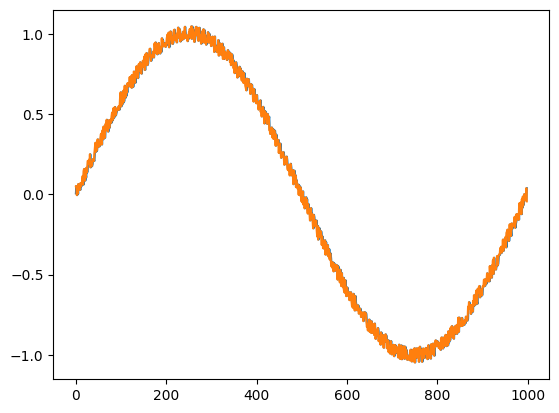

In [4]:
# RNN 预测正弦波：
import numpy as np
import dezero
from dezero.core import Variable

import matplotlib.pyplot as plt
from imp import reload
import dezero.datasets
reload(dezero.datasets)

train_set = dezero.datasets.SinCurve(train = True)
print( train_set[0])
print(train_set[1])
print(train_set[2])
# visualize dataset
xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label = 'xs')
plt.plot(np.arange(len(ts)), ts, label = 'ts')
plt.show()


In [5]:
# training sop
max_epoch = 100
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train = True)
seqlen = len(train_set) # 999

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x,t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            # truncate bptt
            loss.unchain_backward()
            optimizer.update()
    
    avg_loss = float(loss.data) / count
    print(f'epoch: {epoch+1}, loss: {avg_loss}')


            

epoch: 1, loss: 0.1268418932183658
epoch: 2, loss: 0.06958010748250275
epoch: 3, loss: 0.026226117723291385
epoch: 4, loss: 0.014710477920568047
epoch: 5, loss: 0.00882071003662505
epoch: 6, loss: 0.006610475343793306
epoch: 7, loss: 0.0034080554079374036
epoch: 8, loss: 0.004126823447271738
epoch: 9, loss: 0.0032839126152286713
epoch: 10, loss: 0.005121801341545663
epoch: 11, loss: 0.009132425544911938
epoch: 12, loss: 0.012371821048438805
epoch: 13, loss: 0.008967546824647744
epoch: 14, loss: 0.005087431325785504
epoch: 15, loss: 0.00450150414234635
epoch: 16, loss: 0.005269376712664359
epoch: 17, loss: 0.0065509401002136645
epoch: 18, loss: 0.007500187393160384
epoch: 19, loss: 0.007199344492850344
epoch: 20, loss: 0.006288052095055275
epoch: 21, loss: 0.005514716316678442
epoch: 22, loss: 0.005378483070019555
epoch: 23, loss: 0.005626243696979594
epoch: 24, loss: 0.0058806680545827345
epoch: 25, loss: 0.006111582295195382
epoch: 26, loss: 0.006105222349751245
epoch: 27, loss: 0.006

C:\Users\xuguy\AppData\Local\Temp\ipykernel_31552\2490468763.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_list.append(float(y.data))


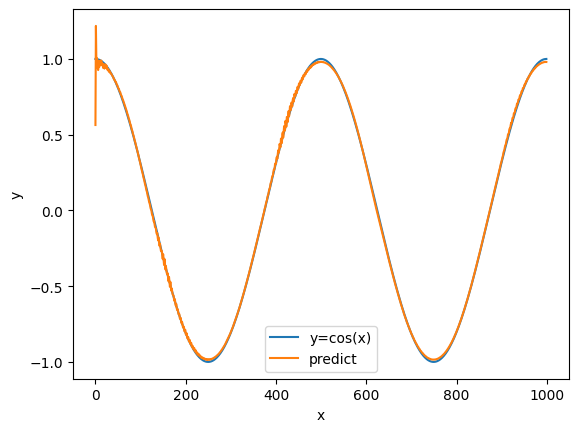

In [6]:
# check performance of RNN
import matplotlib.pyplot as plt
xs = np.cos(np.linspace(0, 4*np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label = 'y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label = 'predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()